# Import Libraries

In [1]:
# standard library
import os
import re
import sys
import subprocess
import importlib.util
import random

# third-party
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.regressionplots import plot_partregress
import joblib

# local imports
from scripts.helpers import map_to_color
from scripts.lower_dim import compute_pcs

from helper import *
from helper.analysis import build_effects_from_correlated_snps, gwas_linregress, summarize_component_fits, center_geno_by_ps, get_n_pcs
from helper.poly_analysis import polygenic_noise

In [2]:
def fit_line(x_, y_):
    slope, intercept, r, p, se = stats.linregress(x_, y_)
    neglogp = -np.log10(p) if p > 0 else np.inf
    return slope, intercept, neglogp

# Load data

In [3]:
raw_geno, humans = load_data()

In [4]:
pheno = make_pheno(humans)

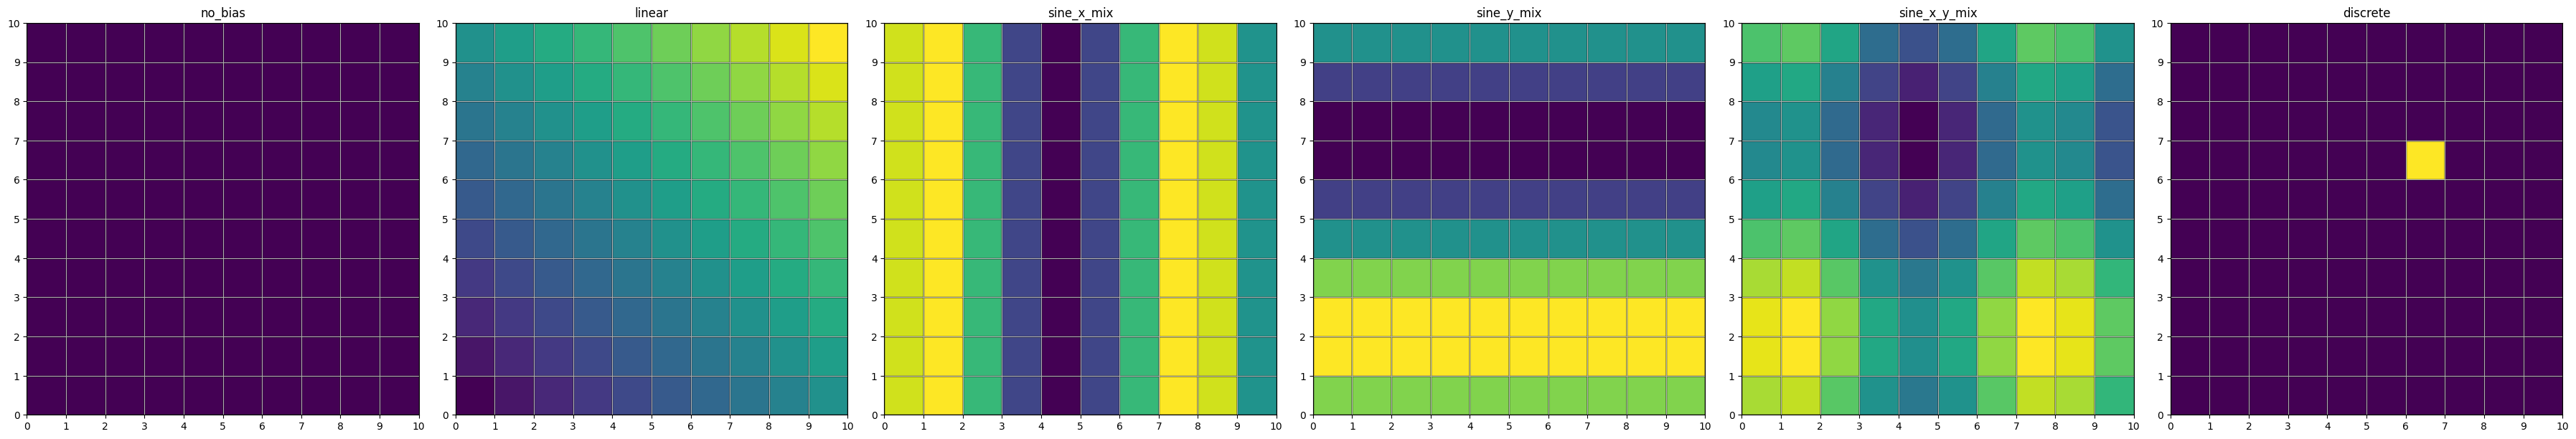

In [5]:
show_biases(pheno)

In [6]:
chosen_bias = "discrete"
pheno[chosen_bias] = (pheno[chosen_bias] - pheno[chosen_bias].mean()) / pheno[chosen_bias].std()

In [7]:
G, snp_cols, pcs = _prep_geno_and_pcs(raw_geno, PCs=5)
G.shape, len(snp_cols), pcs.shape

((2000, 8000), 8000, (2000, 5))

In [9]:
values, pcs, ps, HWE_dev = find_snps(raw_geno, pop=humans["populations"], chosen_bias=pheno["discrete"], PCs=5)

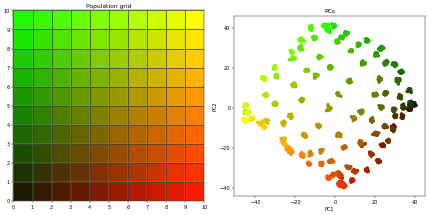

In [10]:
visualize_grid_and_pcs(pcs, humans, dpi=36, s=48)

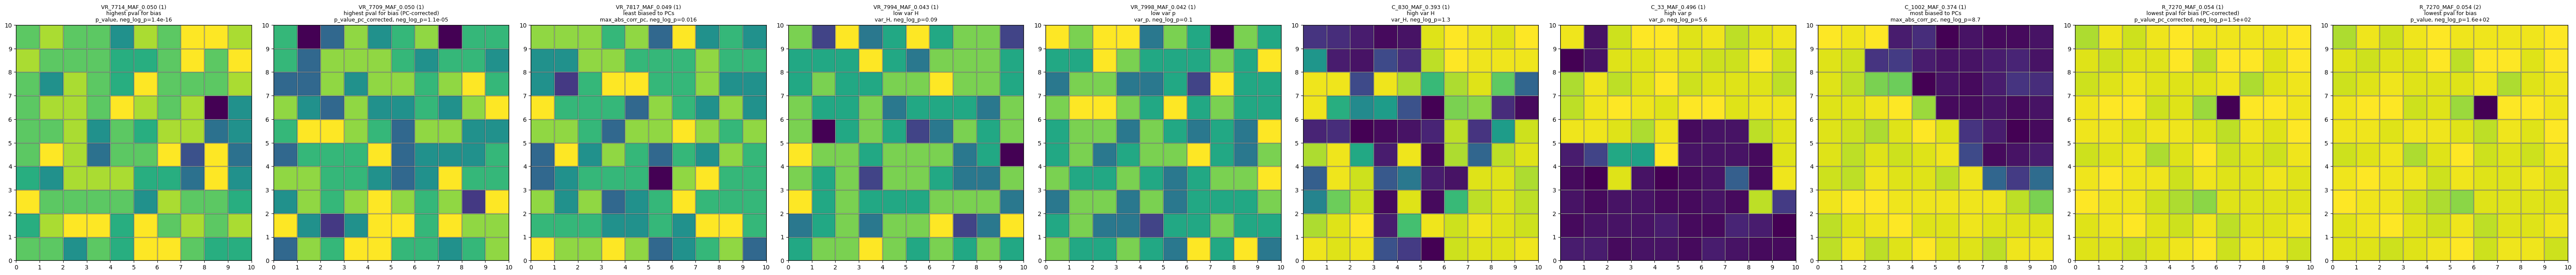

In [11]:
show_top_snps_ordered(humans, raw_geno, values)

In [12]:
chosen_snp = values.loc[
    values["reasons"] == "lowest pval for bias (PC-corrected)", "names"
].iloc[0]

# Standardize genotype

In [13]:
geno, std_params = standardize_and_return_params(raw_geno)

In [14]:
# Find the snps most and least correlated with chosen snp

In [15]:
mean_abs_corr, corr_df_sorted, correlated_snps = snp_correlation_analysis(
    geno,chosen_snp,
    top_k=5
)

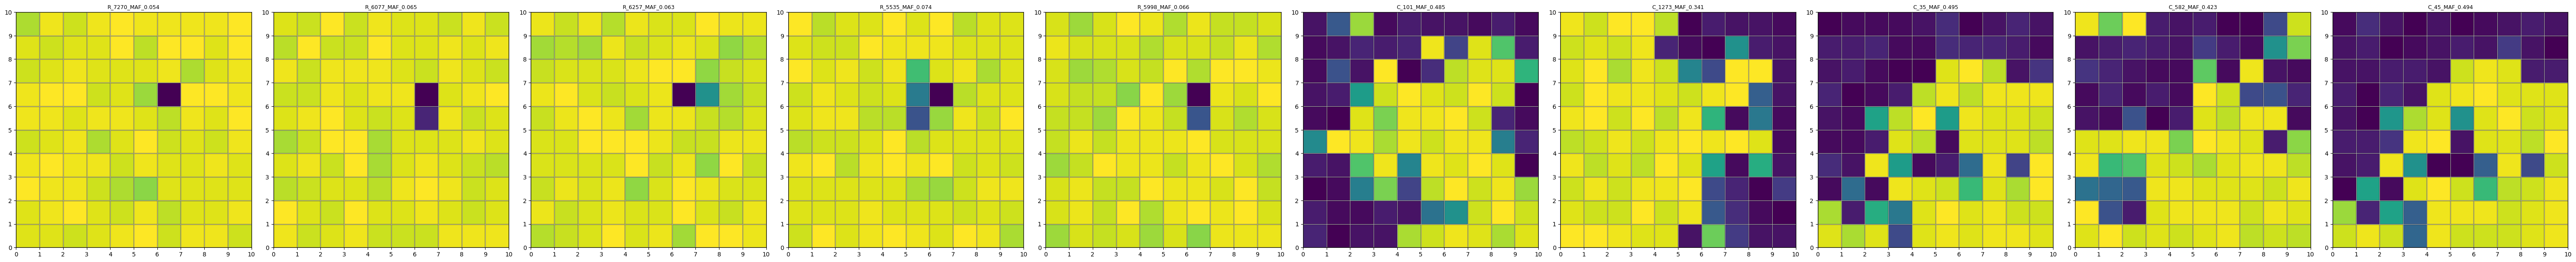

In [16]:
show_corr_snps_ordered(humans, geno, correlated_snps)

# generate Polygenic Noise

In [17]:
chosen_snp = chosen_snp
effect_chosen_snp = 1
chosen_bias = chosen_bias
effect_bias = 1
qty_neg_correlated_with_chosen_snp = 6
effect_neg_corrs = 1
qty_pos_correlated_with_chosen_snp = 6
effect_pos_corrs = 1
percentage_of_polygenic_snps = 20
effect_poly_snps = 1

# effect for the chosen causal snp
pheno['chosen_snp_effect'] = geno[chosen_snp]*effect_chosen_snp
# effect for the most correlared snps
neg_corr_snps = list(corr_df_sorted.tail(qty_neg_correlated_with_chosen_snp)['snp'])
pos_corr_snps = list(corr_df_sorted.head(qty_pos_correlated_with_chosen_snp)['snp'])

pheno['neg_corr_snps_effect'] = 0
pheno['pos_corr_snps_effect'] = 0
for snp in neg_corr_snps:
    pheno['neg_corr_snps_effect'] += geno[snp]*effect_neg_corrs
for snp in pos_corr_snps:
    pheno['pos_corr_snps_effect'] += geno[snp]*effect_pos_corrs

nr_of_snps_to_select = int((geno.shape[1]*percentage_of_polygenic_snps)/100)
excluded_snps = set([chosen_snp]) | set(neg_corr_snps) | set(pos_corr_snps)
candidate_snps = [snp for snp in geno.columns if snp not in excluded_snps]
if nr_of_snps_to_select > len(candidate_snps):
    raise ValueError("Not enough candidate SNPs to sample from.")
selected_poly_snps = random.sample(candidate_snps, nr_of_snps_to_select)

pheno['polygenic_effect'] = 0
per_snp_effect = effect_poly_snps / nr_of_snps_to_select

for snp in selected_poly_snps:
    pheno['polygenic_effect'] += geno[snp] * per_snp_effect

pheno['total_pre_pop'] = pheno["chosen_snp_effect"] + pheno["pos_corr_snps_effect"] + pheno["neg_corr_snps_effect"] + pheno["polygenic_effect"]
pheno['total'] = pheno[chosen_bias] + pheno['total_pre_pop']

In [18]:

# --- build non-zero betas ---
snps_betas = pd.concat(
    [
        pd.DataFrame({
            "snp": [chosen_snp],
            "beta": [effect_chosen_snp],
            "category": ["chosen"],
        }),
        pd.DataFrame({
            "snp": neg_corr_snps,
            "beta": effect_neg_corrs,
            "category": "neg_corr",
        }),
        pd.DataFrame({
            "snp": pos_corr_snps,
            "beta": effect_pos_corrs,
            "category": "pos_corr",
        }),
        pd.DataFrame({
            "snp": selected_poly_snps,
            "beta": per_snp_effect,  # effect_poly_snps / nr_of_snps_to_select
            "category": "polygenic",
        }),
    ],
    ignore_index=True,
)

# --- enforce uniqueness BEFORE merge (critical) ---
snps_betas = snps_betas.drop_duplicates(subset="snp", keep="first")

# --- expand to all SNPs, fill missing with zero, enforce order ---
snps_betas = (
    pd.DataFrame({"snp": geno.columns})
    .merge(snps_betas, on="snp", how="left")
    .assign(
        beta=lambda df: df["beta"].fillna(0),
        category=lambda df: df["category"].fillna("null"),
    )
    .set_index("snp")
    .loc[geno.columns]
    .reset_index()
)


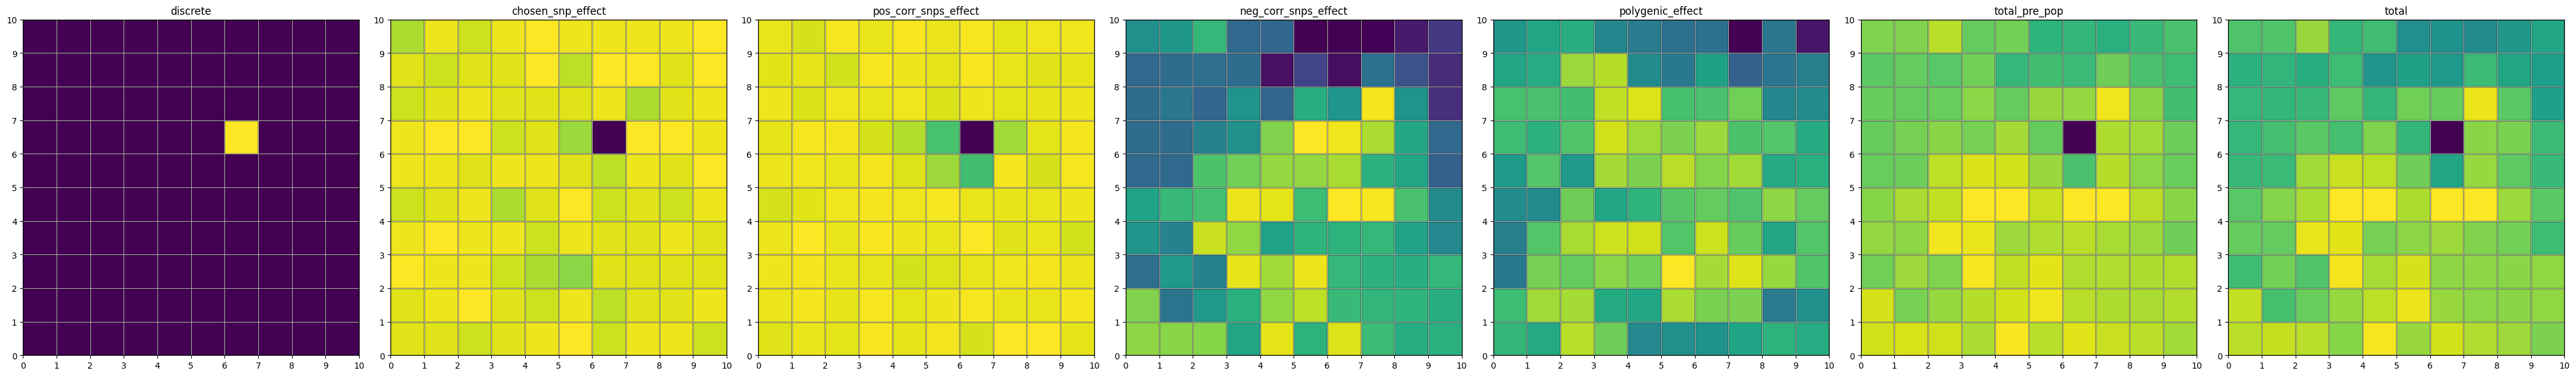

In [19]:
cols = [chosen_bias, "chosen_snp_effect", "pos_corr_snps_effect", "neg_corr_snps_effect","polygenic_effect","total_pre_pop","total"]
plot_effects(pheno,cols)

# perceived betas pre-without pop

In [20]:
perceived_beta = []
neglops = []
for snp in geno.columns:
    slope, intercept, neglogp = fit_line(geno[snp], pheno['total_pre_pop'])
    perceived_beta.append(slope)
    neglops.append(neglogp)

snps_betas['perceived_beta_pre_pop'] = perceived_beta
snps_betas['neglogp_pre_pop'] = neglops


perceived_beta = []
neglops = []
for snp in geno.columns:
    slope, intercept, neglogp = fit_line(geno[snp], pheno['total'])
    perceived_beta.append(slope)
    neglops.append(neglogp)

snps_betas['perceived_beta_with_pop'] = perceived_beta
snps_betas['neglogp_with_pop'] = neglops

snps_betas['marginal_effect'] = snps_betas["beta"] - snps_betas['perceived_beta_pre_pop']

In [21]:
# Estimated marginal effect pre correction

In [22]:
snps_pcs = get_n_pcs(geno.T, 25)

In [23]:
def estimate_marginal_effect(pc_df, effect_df, effect, chosen_snp):
    temp_df = pd.DataFrame()
    chosen_vec = pc_df.loc[chosen_snp].values
    all_vecs = pc_df.values
    distances = np.linalg.norm(all_vecs - chosen_vec, axis=1)
    temp_df['names'] = pc_df.index
    temp_df['distances'] = distances
    temp_df = temp_df[temp_df['names']!=chosen_snp]
    merged = temp_df.merge(effect_df,left_on="names",right_on="index",how="inner")

    # compute weighted sum
    weighted_sum = (merged["distances"] * merged[effect]).sum()/len(pc_df)
    return weighted_sum

In [24]:
esti_marg_effects=[]
for snp in snps_betas["index"]:
    esti_marg_effects.append(estimate_marginal_effect(snps_pcs, snps_betas, "perceived_beta_with_pop", snp))

In [25]:
snps_betas['esti_marginal_pre_corr'] = esti_marg_effects

In [26]:
snps_betas

,index,beta,category,perceived_beta_pre_pop,neglogp_pre_pop,perceived_beta_with_pop,neglogp_with_pop,marginal_effect,esti_marginal_pre_corr
0,C_1_MAF_0.500,0.000625,polygenic,0.477616,5.035064,0.472109,6.002488,-0.476991,-0.815991
1,C_2_MAF_0.500,0.000000,null,-0.347559,2.897139,-0.249034,1.999360,0.347559,2.006123
2,C_3_MAF_0.500,0.000625,polygenic,0.337539,2.757645,0.240867,1.894561,-0.336914,0.633520
3,C_4_MAF_0.500,0.000000,null,-0.408411,3.821199,-0.305166,2.797684,0.408411,2.087919
4,C_5_MAF_0.500,0.000625,polygenic,0.396006,3.622049,0.298327,2.693066,-0.395381,0.740744
...,...,...,...,...,...,...,...,...,...
7995,VR_7996_MAF_0.042,0.000000,null,0.047158,0.178968,0.041664,0.175987,-0.047158,0.980172
7996,VR_7997_MAF_0.042,0.000000,null,0.065983,0.266729,0.077704,0.374687,-0.065983,0.685653
7997,VR_7998_MAF_0.042,0.000000,null,0.015248,0.051740,0.009406,0.034998,-0.015248,1.058784
7998,VR_7999_MAF_0.042,0.000625,polygenic,0.058202,0.229278,0.034656,0.142503,-0.057577,1.234904


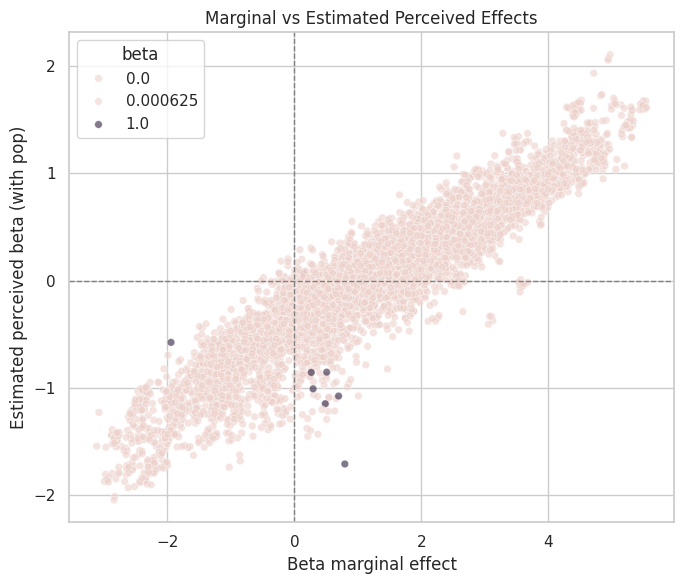

In [27]:
sns.set(style="whitegrid")

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=snps_betas,
    x="esti_marginal_pre_corr",
    y="marginal_effect",
    hue="beta",
    alpha=0.6,
    s=30
)

plt.axhline(0, color="grey", linestyle="--", linewidth=1)
plt.axvline(0, color="grey", linestyle="--", linewidth=1)

plt.xlabel("Beta marginal effect")
plt.ylabel("Estimated perceived beta (with pop)")
plt.title("Marginal vs Estimated Perceived Effects")

plt.tight_layout()
plt.show()


In [68]:
# With correction

In [28]:
geno_corr = raw_geno - ((ps - (1-ps))+1)/2

In [29]:
std_corr = (((ps*(1-ps)*2)+1)/2).mean(axis=0)

In [30]:
geno_corr = geno_corr/std_corr

In [31]:
perceived_beta = []
neglops = []
for snp in geno.columns:
    slope, intercept, neglogp = fit_line(geno_corr[snp], pheno['total_pre_pop'])
    perceived_beta.append(slope)
    neglops.append(neglogp)

snps_betas['perceived_beta_pre_pop_corr'] = perceived_beta
snps_betas['neglogp_pre_pop_corr'] = neglops
 

perceived_beta = []
neglops = []
for snp in geno.columns:
    slope, intercept, neglogp = fit_line(geno_corr[snp], pheno['total'])
    perceived_beta.append(slope)
    neglops.append(neglogp)

snps_betas['perceived_beta_with_pop_corr'] = perceived_beta
snps_betas['neglogp_with_pop_corr'] = neglops

snps_betas['marginal_effect_corr'] = snps_betas["beta"] - snps_betas['perceived_beta_pre_pop_corr']

In [32]:
esti_marg_effects=[]
for snp in snps_betas["index"]:
    esti_marg_effects.append(estimate_marginal_effect(snps_pcs, snps_betas, "perceived_beta_with_pop_corr", snp))

In [33]:
snps_betas['esti_marginal_corr'] = esti_marg_effects

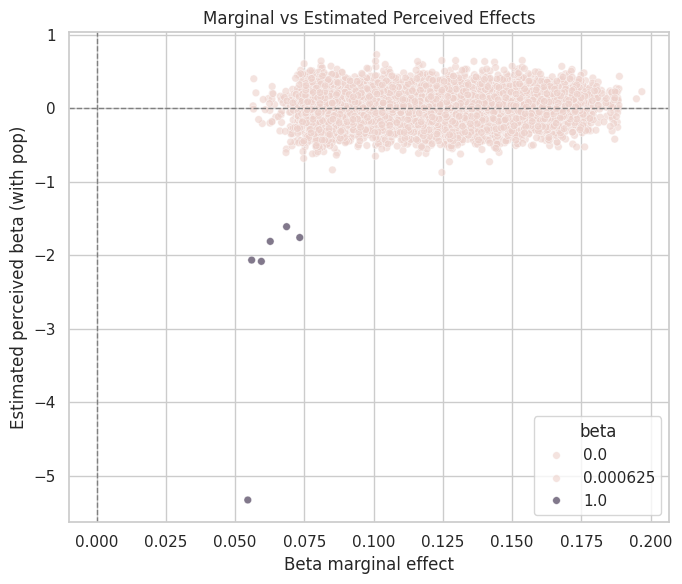

In [34]:
sns.set(style="whitegrid")

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=snps_betas,
    x="esti_marginal_corr",
    y="marginal_effect_corr",
    hue="beta",
    alpha=0.6,
    s=30
)

plt.axhline(0, color="grey", linestyle="--", linewidth=1)
plt.axvline(0, color="grey", linestyle="--", linewidth=1)

plt.xlabel("Beta marginal effect")
plt.ylabel("Estimated perceived beta (with pop)")
plt.title("Marginal vs Estimated Perceived Effects")

plt.tight_layout()
plt.show()


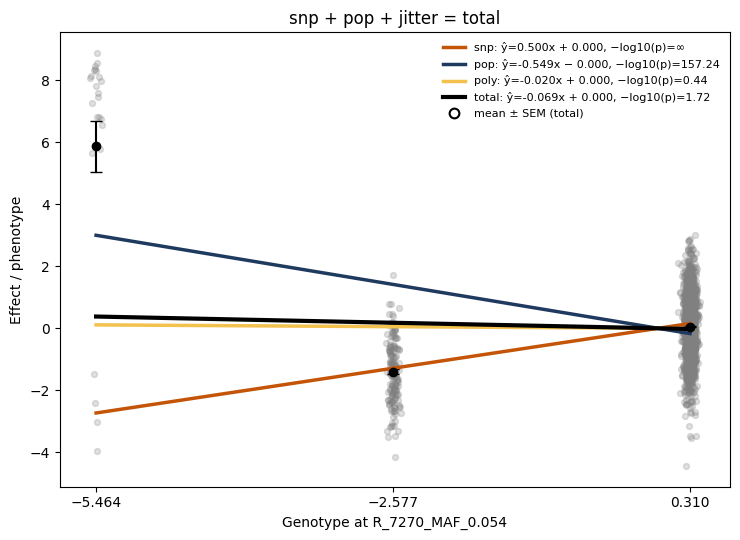

In [23]:
params = plot_components_vs_snp(geno, chosen_snp, effects)

In [24]:
params

{'snp': {'beta': 0.49987497937359227,
  'intercept': 8.346301002741667e-17,
  'neglogp': inf},
 'pop': {'beta': -0.5490613013496987,
  'intercept': -1.4866527734469956e-16,
  'neglogp': 157.24043329508578},
 'poly': {'beta': -0.020240635014883372,
  'intercept': 5.690089850888681e-10,
  'neglogp': 0.43711710109109636},
 'total': {'beta': -0.06942695699098819,
  'intercept': 5.690089714009491e-10,
  'neglogp': 1.7200814570132497}}

In [43]:
corr = ((p-(1-p)+1)/2)
corr = (corr - snp_mean) / snp_std

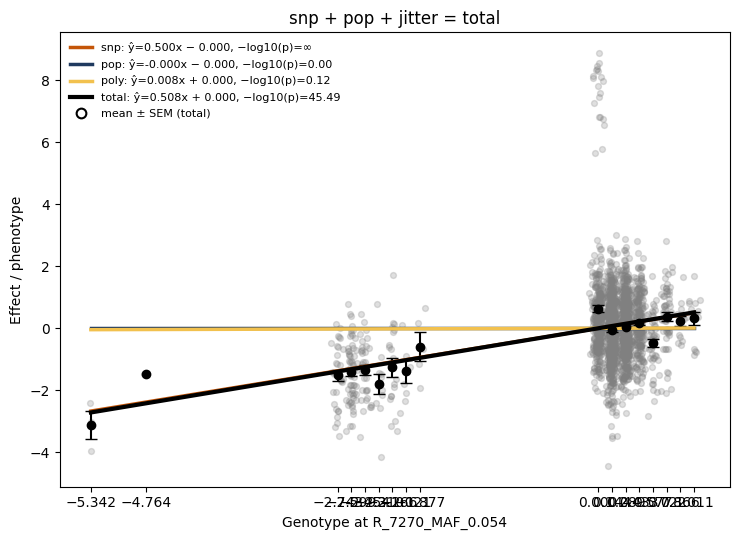

In [47]:
params_corr = plot_components_vs_snp(geno-corr, chosen_snp, effects)

In [48]:
# For all other SNPs now

In [49]:
effects["total_minus_snp_effect"] = effects["total"] - params_corr['total']['beta']*geno[chosen_snp]

In [50]:
len(geno.columns.drop(chosen_snp))

7999

In [51]:
rows = []
to_use = geno-corr
for snp in geno.columns.drop(chosen_snp):
    slope, intercept, neglogp = fit_line(
        to_use[snp],
        effects["total_minus_snp_effect"]
    )
    rows.append({
        "snp": snp,
        "slope": slope,
        "intercept": intercept,
        "neglogp": neglogp
    })

vals = pd.DataFrame(rows)


In [52]:
vals

,snp,slope,intercept,neglogp
0,C_1_MAF_0.500,-0.044497,5.690091e-10,0.275639
1,C_2_MAF_0.500,-0.032664,5.690091e-10,0.167299
2,C_3_MAF_0.500,0.049859,5.690091e-10,0.261097
3,C_4_MAF_0.500,-0.085440,5.690091e-10,0.545852
4,C_5_MAF_0.500,-0.034113,5.690091e-10,0.169625
...,...,...,...,...
7994,VR_7996_MAF_0.042,0.005578,5.690091e-10,0.062061
7995,VR_7997_MAF_0.042,0.022066,5.690091e-10,0.297539
7996,VR_7998_MAF_0.042,-0.010438,5.690091e-10,0.124557
7997,VR_7999_MAF_0.042,0.003156,5.690091e-10,0.034245


In [53]:
error_beta = params_corr['total']['beta']-params_corr['snp']['beta']
error_beta

0.00833875987434246

In [54]:
vals['slope'].mean()

-0.0003172816860716118

In [55]:
vals["slope"].sum()

-2.5379362068868225

In [35]:
def plot_components_vs_x(x, y, covs=None, jitter=0.03):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from scipy import stats

    if covs is None:
        covs = []

    # coerce x
    x = np.asarray(x, dtype=float)

    # coerce y into a dict of named components
    if isinstance(y, dict):
        ys = {k: np.asarray(v, dtype=float) for k, v in y.items()}
    else:
        ys = {"total": np.asarray(y, dtype=float)}

    # coerce covariates (currently only for NaN-alignment)
    covs = [np.asarray(c, dtype=float) for c in covs]

    # build joint matrix for NaN filtering
    X = np.column_stack([x] + list(ys.values()) + covs)
    X = X[~np.isnan(X).any(axis=1)]

    x = X[:, 0]
    n_y = len(ys)
    y_keys = list(ys.keys())
    ys = {k: X[:, i + 1] for i, k in enumerate(y_keys)}
    covs = [X[:, 1 + n_y + i] for i in range(len(covs))]  # kept for future use

    def fit_line(x_, y_):
        slope, intercept, r, p, se = stats.linregress(x_, y_)
        neglogp = -np.log10(p) if p > 0 else np.inf
        return slope, intercept, neglogp

    def pretty(name, slope, intercept, neglogp):
        ptxt = "∞" if np.isinf(neglogp) else f"{neglogp:.2f}"
        return f"{name}: ŷ={intercept:.3f} {slope:+.3f}x, −log10(p)={ptxt}"

    # defaults similar to your original
    default_colors = {
        "snp":   "#c45508",
        "pop":   "#1f3a5f",
        "poly":  "#f2c14e",
        "total": "#000000",
    }

    order = [k for k in ["snp", "pop", "poly", "total"] if k in ys] + \
            [k for k in y_keys if k not in {"snp", "pop", "poly", "total"}]

    plt.figure(figsize=(7.5, 5.5))

    rng = np.random.default_rng(0)

    # scatter + mean±SEM only if x looks discrete-ish and "total" exists
    if "total" in ys:
        plt.scatter(
            x + rng.normal(0, jitter, size=len(x)),
            ys["total"],
            alpha=0.25,
            s=18,
            color="0.5",
        )

        uniq = np.unique(x)
        if uniq.size <= 20:  # heuristic: treat as grouped genotype-like
            for g in sorted(uniq):
                mask = (x == g)
                if mask.sum() >= 2:
                    mean = ys["total"][mask].mean()
                    sem = ys["total"][mask].std(ddof=1) / np.sqrt(mask.sum())
                else:
                    mean = ys["total"][mask].mean()
                    sem = 0.0

                plt.errorbar(
                    [g], [mean], yerr=[sem],
                    fmt="o", capsize=4,
                    color=default_colors.get("total", "black"),
                )

            mean_sem_handle = Line2D(
                [0], [0],
                marker="o",
                linestyle="none",
                markersize=7,
                markerfacecolor="none",
                markeredgewidth=1.5,
                color="black",
                label="mean ± SEM (total)",
            )
        else:
            mean_sem_handle = None
    else:
        mean_sem_handle = None

    x_line = np.array([x.min(), x.max()])

    params = {}
    for name in order:
        slope, intercept, neglogp = fit_line(x, ys[name])
        params[name] = {"beta": slope, "intercept": intercept, "neglogp": neglogp}

        color = default_colors.get(name, None)
        plt.plot(
            x_line,
            intercept + slope * x_line,
            linewidth=3 if name == "total" else 2.5,
            color=color,
            label=pretty(name, slope, intercept, neglogp),
            zorder=3 if name == "total" else 2,
        )

    # axis/labels
    uniq = np.unique(x)
    if uniq.size <= 20:
        plt.xticks(sorted(uniq))

    plt.xlabel("x")
    plt.ylabel("y / effect")
    plt.title("components vs x")

    # legend
    handles, labels = plt.gca().get_legend_handles_labels()
    if mean_sem_handle is not None:
        handles.append(mean_sem_handle)
        labels.append(mean_sem_handle.get_label())
    plt.legend(handles, labels, frameon=False, fontsize=8)

    plt.tight_layout()
    plt.show()

    return params


In [36]:
#covs = [pcs[c] for c in [pc1, pc2]]
y = geno[chosen_snp]          # e.g. something = "height"


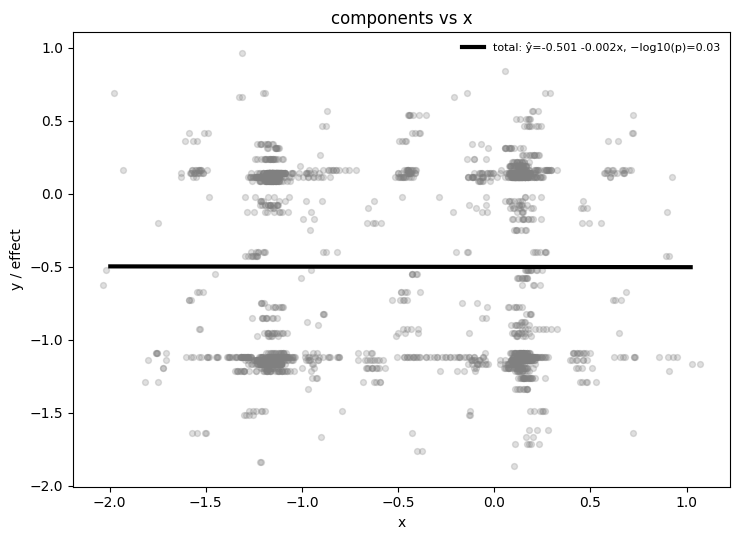

{'total': {'beta': -0.0018236390302639493,
  'intercept': -0.501161819515132,
  'neglogp': 0.030311253415093463}}

In [37]:
plot_components_vs_x(geno-corr, y, covs=None, jitter=0.03)

In [38]:
params_corr

{'snp': {'beta': 0.527282828817948,
  'intercept': 0.4989413767689834,
  'neglogp': inf},
 'pop': {'beta': -0.5089797329435355,
  'intercept': -0.48162207229782067,
  'neglogp': 115.49450879538466},
 'poly': {'beta': -0.01769712505441796,
  'intercept': -0.01674590401373401,
  'neglogp': 0.342060943573539},
 'total': {'beta': 0.0006059708199952457,
  'intercept': 0.000573400457429487,
  'neglogp': 0.006743968994860963}}

In [39]:
params_corr['total']['beta']

0.0006059708199952457

In [40]:
Expected_snp_effect = params_corr['total']['beta']*geno[chosen_snp] + params['total']['intercept']

In [41]:
Expected_snp_effect

0       0.000188
1      -0.001562
2       0.000188
3       0.000188
4       0.000188
          ...   
1995    0.000188
1996    0.000188
1997    0.000188
1998    0.000188
1999    0.000188
Name: R_7270_MAF_0.054, Length: 2000, dtype: float64

In [42]:
effects['total'].mean()

5.69008985706887e-10